In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import logging

In [2]:
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:
import importlib
import euler_utils
importlib.reload(euler_utils)

<module 'euler_utils' from '/cluster/home/mfrancesc/IVT/WaitTimeValidation/euler_utils.py'>

In [4]:
last_iter = 100

In [ ]:
no_rej_4000 = euler_utils.read_output('/cluster/scratch/mfrancesc/IVT/SA_scenario/no_rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_4000['drt_trips_stats'])

 93%|█████████▎| 94/101 [02:50<00:16,  2.40s/it]

In [ ]:
no_rej_6000 = euler_utils.read_output('/cluster/scratch/mfrancesc/IVT/SA_scenario/no_rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_6000['drt_trips_stats'])

In [ ]:
rej_4000 = euler_utils.read_output('/cluster/scratch/mfrancesc/IVT/SA_scenario/rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_4000['drt_trips_stats'])

In [ ]:
rej_6000 = euler_utils.read_output('/cluster/scratch/mfrancesc/IVT/SA_scenario/rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_6000['drt_trips_stats'])

In [9]:
def avg_by_time_bin(drt_trips_stats, column, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_trips_stats.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.startTime, bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['time_bin'])[column].mean()
    return grouped

In [10]:
def plot_column_by_time(drt_trips_stats, column, start_time=6, end_time=24, bin_duration_min=30, metric_unit=None, metric_factor = 1, start_iter=None):
    n_iters = len(drt_trips_stats)
    for it in range(start_iter if start_iter is not None else n_iters-1,n_iters):
        avg_by_bin = avg_by_time_bin(drt_trips_stats[it], column, start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
        xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
        xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
        # TODO: Delete point o in plot if we have data available in all bins (if there are nan values then
        # without the o point we don't see all the points)
        plt.plot(avg_by_bin.index.values, avg_by_bin.values/metric_factor, 'o-', label='Iter ' + str(it))
        plt.xlim(start_time*3600,end_time*3600)
        plt.xticks(xticks, xticks_labels)
    
    
    plt.xlabel('Time of the day')
    plt.ylabel(column + ' (' + metric_unit + ')' if metric_unit else column)
    plt.legend()
    plt.show()
    

In [60]:
def avg_by_euclidean_distance_bin(drt_trips_stats, column, min_distance=0, max_distance=5000, bins_resolution=200):
    legs = drt_trips_stats.copy()
    legs = legs[~np.isinf(legs['delayFactor'])]
    n_bins = (max_distance - min_distance) // bins_resolution
    distance_bins = [i*bins_resolution for i in range(n_bins + 1)]
    legs['euclidean_distance'] = np.sqrt((legs.startX - legs.endX)**2 + (legs.startY - legs.endY)**2)
    legs['distance_bin'] = pd.cut(legs.euclidean_distance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['routerUnsharedTime'].sum()
    else:
        if np.isinf(legs[column]).any():
            logging.warning('Only using rows without inf in the column')
            legs = legs[~np.isinf(legs[column])]
        grouped = legs.groupby(['distance_bin'])[column].mean()
    return grouped

In [12]:
def plot_column_by_euclidean_distance(drt_trips_stats, column, min_distance=0, max_distance=10000, bins_resolution=200, metric_unit=None, metric_factor = 1, start_iter=None):
    n_iters = len(drt_trips_stats)
    for it in range(start_iter if start_iter is not None else n_iters-1,n_iters):
        avg_by_bin = avg_by_euclidean_distance_bin(drt_trips_stats[it], column, min_distance = min_distance, max_distance = max_distance,
                                        bins_resolution = bins_resolution)
        x = np.array(avg_by_bin.index.values)/1000
        plt.plot(x, avg_by_bin.values / metric_factor, 'o-', label='Iter ' + str(it))

    plt.xlabel('Euclidean distance (km)')
    plt.ylabel(column + ' (' + metric_unit + ')' if metric_unit else column)
    #plt.xticks(np.arange(min_distance/1000, max_distance/1000, 1))
    plt.legend()
    plt.show()

In [56]:
def plot_difference_estimated_router(drt_trips_stats, iter_to_plot=-1):
    filtered = drt_trips_stats[iter_to_plot][drt_trips_stats[iter_to_plot]['routerUnsharedTime'] != 0]
    difference = np.abs(filtered['estimatedUnsharedTime'] - filtered['routerUnsharedTime'])
    difference = difference/60 #/ (filtered['estimatedUnsharedTime']/60)
    print(difference.describe())
    print(difference.quantile(0.99))
    plt.hist(difference, bins=100)
    plt.show()

In [ ]:
def plot_delay_factor(drt_trip_stats):
    
    

In [65]:
def plot_all(output_dict, title=None):
    start_time = 6
    end_time = 24
    bin_duration_min = 5
    print(title)
    plot_column_by_time(output_dict['drt_trips_stats'], 'waitTime', start_time=start_time, end_time=end_time, bin_duration_min=bin_duration_min, metric_unit='min', metric_factor=60)
    plot_column_by_time(output_dict['drt_trips_stats'], 'delayFactor', start_time=start_time, end_time=end_time, bin_duration_min=bin_duration_min)
    plot_column_by_time(output_dict['drt_trips_stats'], 'delayFactor_estimated', start_time=start_time, end_time=end_time, bin_duration_min=bin_duration_min)
    plot_column_by_time(output_dict['drt_trips_stats'], 'compute_total_delay_factor_router', start_time=start_time, end_time=end_time, bin_duration_min=bin_duration_min)
    plot_column_by_time(output_dict['drt_trips_stats'], 'compute_total_delay_factor_estimated', start_time=start_time, end_time=end_time, bin_duration_min=bin_duration_min)
    plot_difference_estimated_router(output_dict['drt_trips_stats'])
    plot_column_by_euclidean_distance(output_dict['drt_trips_stats'], 'waitTime', metric_unit='min', metric_factor=60)
    plot_column_by_euclidean_distance(output_dict['drt_trips_stats'], 'delayFactor')
    plot_column_by_euclidean_distance(output_dict['drt_trips_stats'], 'delayFactor_estimated')
    plot_column_by_euclidean_distance(output_dict['drt_trips_stats'], 'compute_total_delay_factor_router')
    plot_column_by_euclidean_distance(output_dict['drt_trips_stats'], 'compute_total_delay_factor_estimated')

    
    

Multiple plots with different bins

No rejections 4000 vehicles


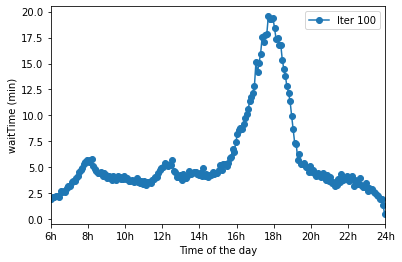

2023-01-05 18:55:44 WARNING  Only using rows without inf in the column


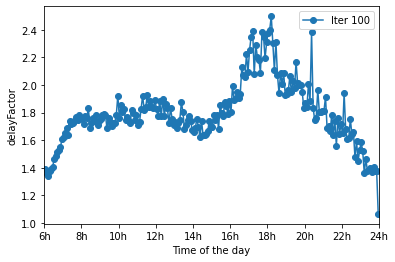

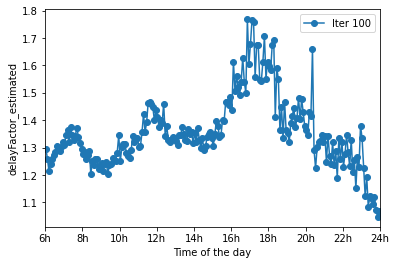

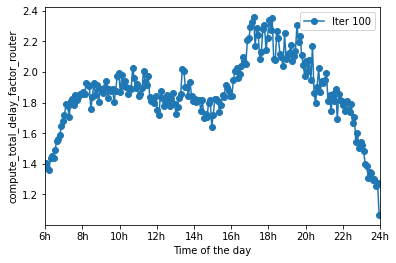

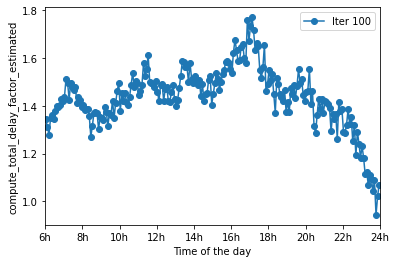

count    215986.000000
mean          1.955866
std           4.494985
min           0.000027
25%           0.271958
50%           0.511535
75%           1.307748
max         199.170861
dtype: float64
22.04081265438893


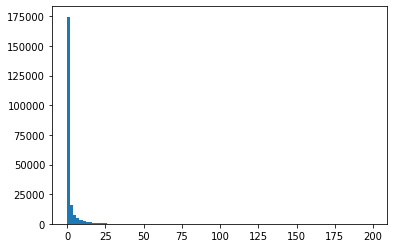

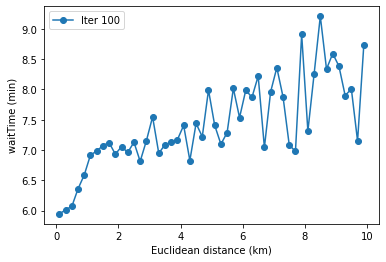

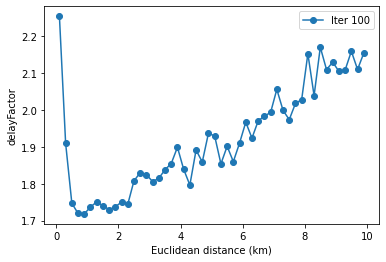

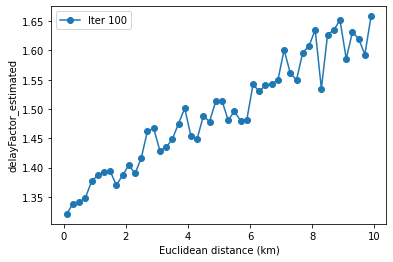

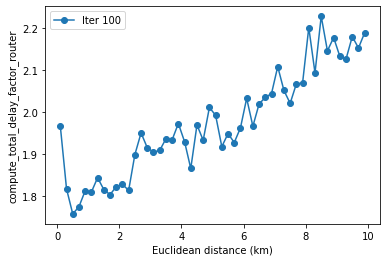

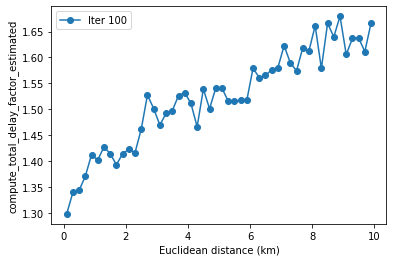

In [66]:
plot_all(no_rej_4000, title='No rejections 4000 vehicles')

No rejections 6000 vehicles


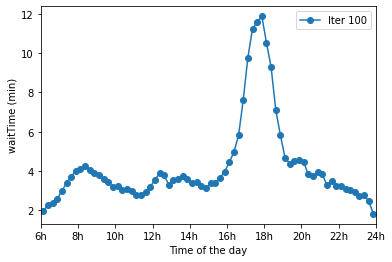

2023-01-05 16:47:32 WARNING  Only using rows without inf in the column


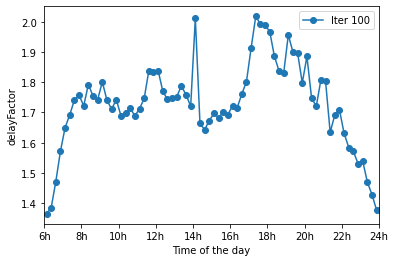

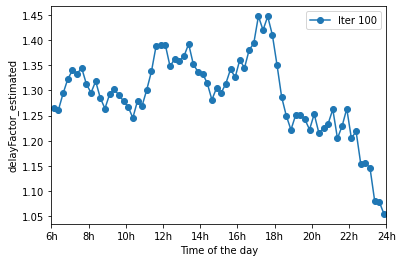

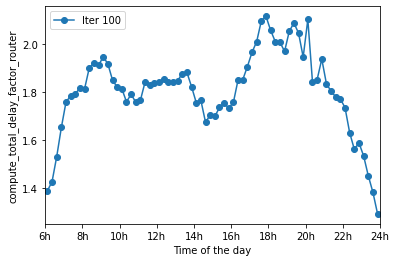

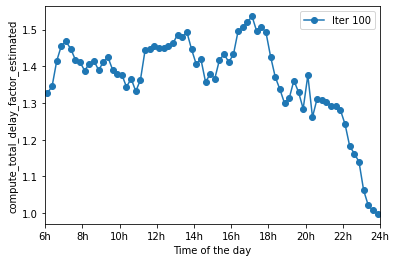

count    245902.000000
mean        110.366037
std         263.166426
min       -8407.783603
25%          15.207292
50%          28.569622
75%          71.938308
max        5429.248508
dtype: float64


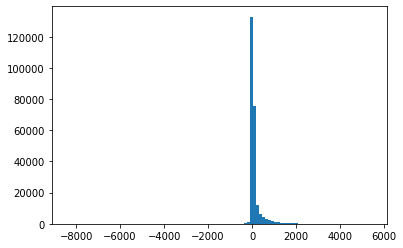

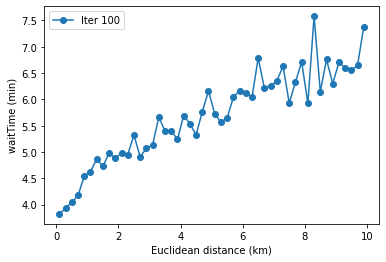

2023-01-05 16:47:33 WARNING  Only using rows without inf in the column


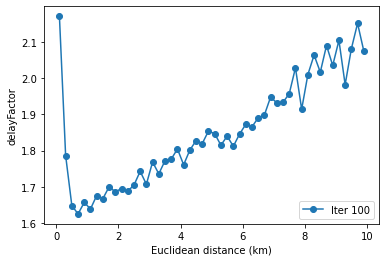

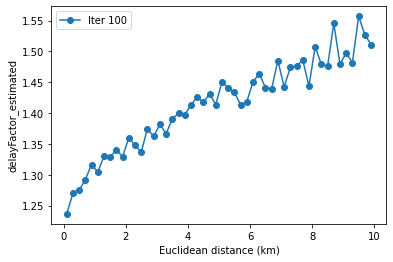

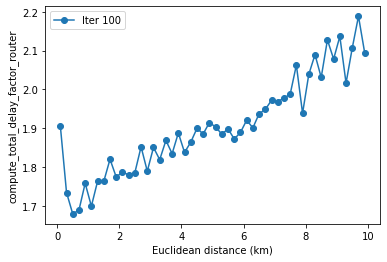

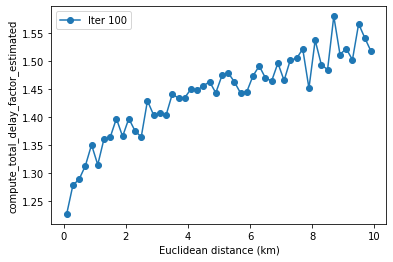

In [16]:
plot_all(no_rej_6000, title='No rejections 6000 vehicles')

Rejections 4000 vehicles


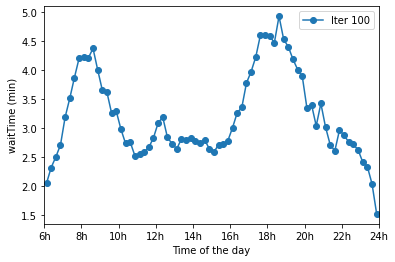

2023-01-05 16:47:34 WARNING  Only using rows without inf in the column


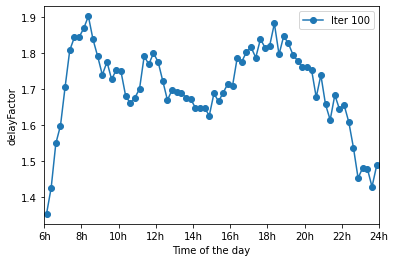

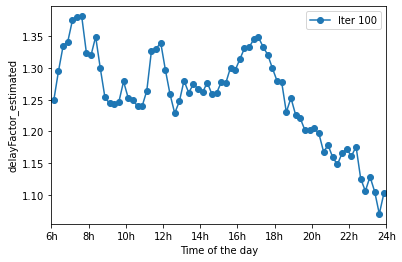

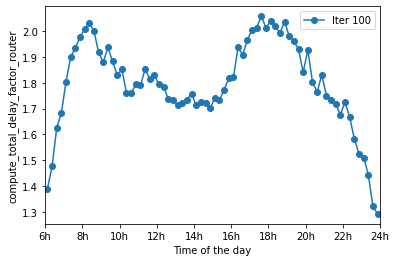

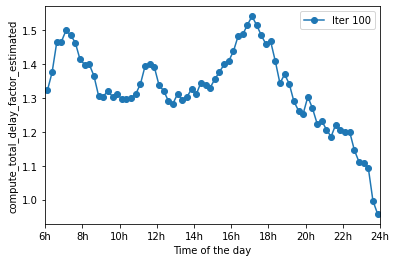

count    181513.000000
mean        129.925550
std         282.505882
min       -4965.805833
25%          15.268722
50%          29.665724
75%          93.291725
max        4899.230102
dtype: float64


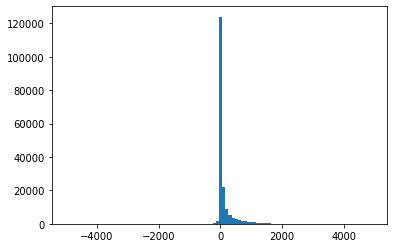

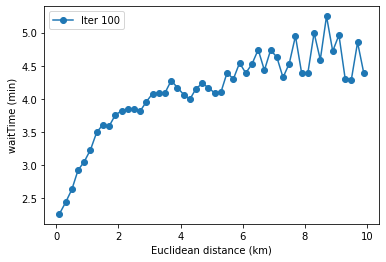

2023-01-05 16:47:35 WARNING  Only using rows without inf in the column


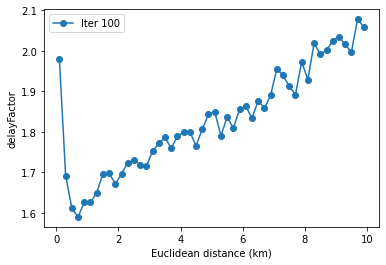

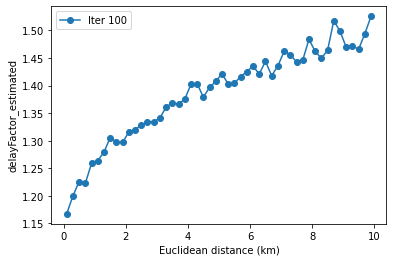

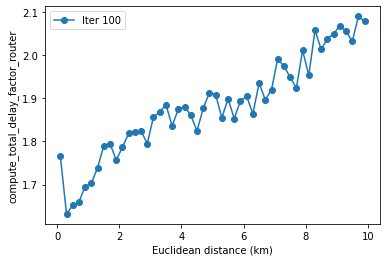

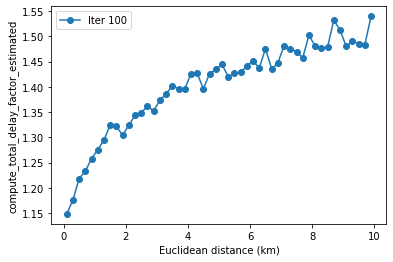

In [17]:
plot_all(rej_4000, title='Rejections 4000 vehicles')

Rejections 6000 vehicles


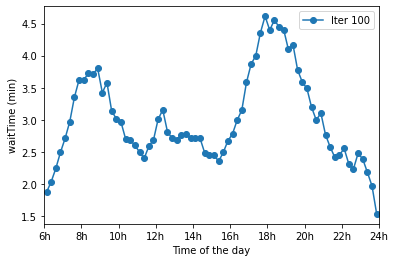

2023-01-05 16:47:36 WARNING  Only using rows without inf in the column


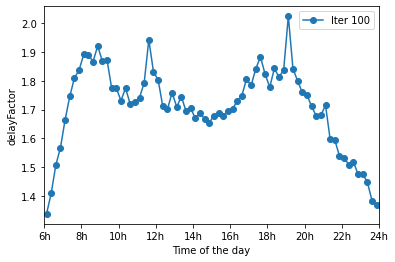

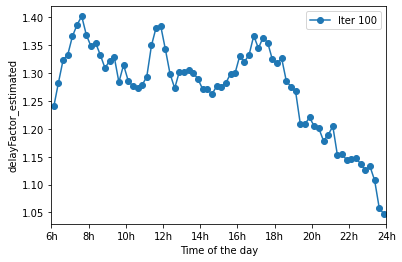

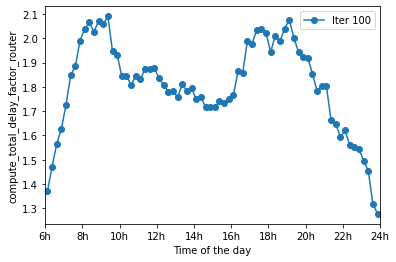

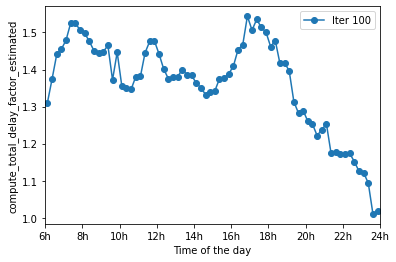

count    212764.000000
mean        117.605438
std         267.193660
min       -3747.106476
25%          14.968513
50%          28.345690
75%          81.260020
max        4584.368522
dtype: float64


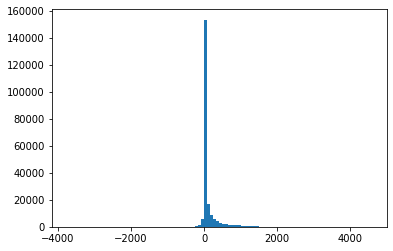

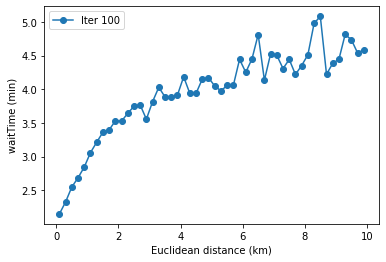

2023-01-05 16:47:37 WARNING  Only using rows without inf in the column


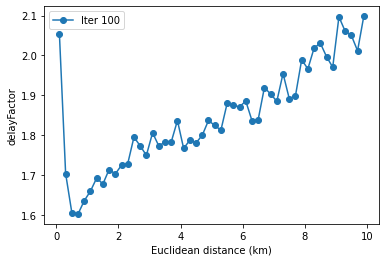

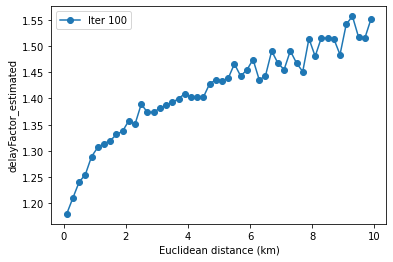

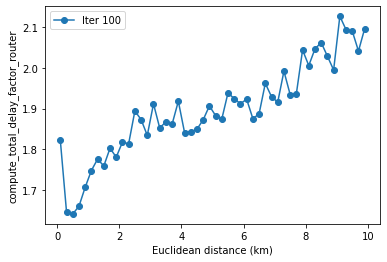

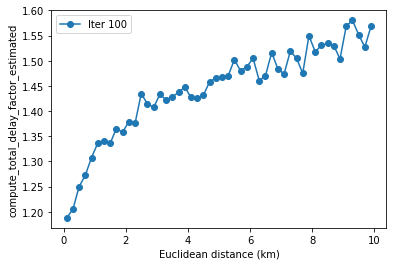

In [18]:
plot_all(rej_6000, title='Rejections 6000 vehicles')

In [19]:
no_rej_4000['drt_trips_stats'][100].columns

Index(['personId', 'startTime', 'totalTravelTime', 'routerUnsharedTime',
       'estimatedUnsharedTime', 'delayFactor', 'waitTime', 'startX', 'startY',
       'endX', 'endY', 'delayFactor_estimated'],
      dtype='object')

In [21]:
no_rej_4000['drt_trips_stats'][100]

,personId,startTime,totalTravelTime,routerUnsharedTime,estimatedUnsharedTime,delayFactor,waitTime,startX,startY,endX,endY,delayFactor_estimated
0,201740004636244,62019.0,89.0,81.515,94.418002,1.091824,193.0,2.681824e+06,1.259072e+06,2.681242e+06,1.258825e+06,0.942617
1,201740008568862,65671.0,1475.0,937.631,1362.749856,1.573114,902.0,2.683445e+06,1.252980e+06,2.678790e+06,1.251416e+06,1.082370
2,201740011111262,76053.0,5115.0,1022.628,1980.019313,5.001819,871.0,2.682604e+06,1.248563e+06,2.675778e+06,1.250827e+06,2.583308
3,201740004701204,57834.0,1401.0,666.957,1016.692096,2.100585,159.0,2.683417e+06,1.250534e+06,2.679568e+06,1.246854e+06,1.377998
4,201740011924315,25615.0,421.0,222.409,246.885588,1.892909,107.0,2.683472e+06,1.253408e+06,2.683430e+06,1.252254e+06,1.705243
...,...,...,...,...,...,...,...,...,...,...,...,...
218235,201740006373040,42777.0,46.0,22.336,46.283169,2.059456,153.0,2.680325e+06,1.246994e+06,2.680058e+06,1.246944e+06,0.993882
218236,201740010041790,50623.0,455.0,203.984,218.908717,2.230567,110.0,2.685260e+06,1.250952e+06,2.686727e+06,1.250696e+06,2.078492
218237,201740011440893,69779.0,966.0,507.926,576.868921,1.901852,126.0,2.682035e+06,1.251466e+06,2.684875e+06,1.251789e+06,1.674557
218238,201740008624799,66459.0,316.0,291.329,313.195966,1.084684,807.0,2.681170e+06,1.252883e+06,2.680274e+06,1.253084e+06,1.008953


In [23]:
no_rej_4000['drt_trips_stats'][100]['euclidean_distance'] =np.sqrt((no_rej_4000['drt_trips_stats'][100].startX - no_rej_4000['drt_trips_stats'][100].endX)**2 + (no_rej_4000['drt_trips_stats'][100].startY - no_rej_4000['drt_trips_stats'][100].endY)**2) 

In [27]:
no_rej_4000['drt_trips_stats'][100]['euclidean_distance'].describe()

count    218240.000000
mean       1734.470370
std        2091.906524
min           5.460794
25%         385.251930
50%         871.133458
75%        2275.178735
max       19963.194883
Name: euclidean_distance, dtype: float64

In [26]:
no_rej_4000['drt_trips_stats'][100][no_rej_4000['drt_trips_stats'][100].delayFactor == np.inf].euclidean_distance.describe()

count    2254.000000
mean      122.576865
std        67.463977
min         8.854271
25%        75.752361
50%       105.962390
75%       153.184299
max       492.057507
Name: euclidean_distance, dtype: float64

In [ ]:
display(no_rej_4000['drt_legs'][100])
display(no_rej_4000['drt_legs'][100]['waitTime'].describe())
display(no_rej_4000['global_avg'][100])

More than 50% of the values are 61s, this happens because the stop duration (defined as 60s in the config file is included in this waiting time), also probably this happens because right now we have very few trips and the vehicles are instantly available in the start location of the trip, we should check if this still happens when we run the simulation with 100% population

From some previous work we know that this stop duration is also counted in the travelTime (for the dropOff)